# **Preprocessing**

https://archive.ics.uci.edu/dataset/791/metropt+3+dataset

In [7]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.patches import Rectangle, Patch
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('data/metropt3_dataset/MetroPT3(AirCompressor).csv')
inital_memory = df.memory_usage(deep=True).sum() / 1024**2
print(f'Initial memory usage: {inital_memory:.2f} MB')

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = df[col].astype(np.float32)

final_memory = df.memory_usage(deep=True).sum() / 1024**2
print(f'Final memory usage: {final_memory:.2f} MB')

df.head()

Initial memory usage: 283.55 MB
Final memory usage: 109.95 MB


,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.599998,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.674999,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.599998,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.424999,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.474998,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


## **1. Motor_Current Visualization**

Text(0, 0.5, 'Motor_current')

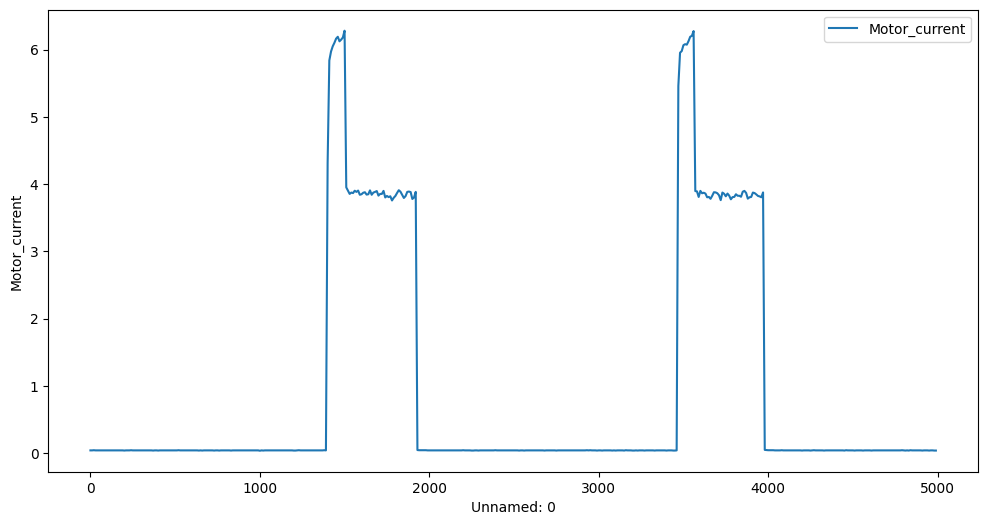

In [3]:
ax = df[:500].plot(x='Unnamed: 0', y='Motor_current', legend=True, figsize=(12, 6))
ax.set_xlabel('Unnamed: 0')
ax.set_ylabel('Motor_current')

## **2. Multivariate variables**

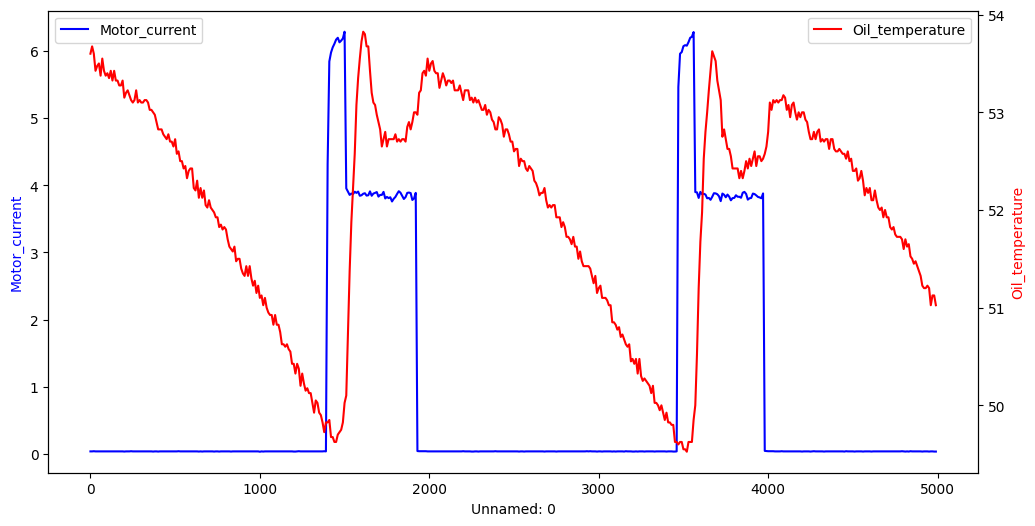

In [4]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

df_sub = df[:500]
p1, = ax1.plot(df_sub['Unnamed: 0'], df_sub['Motor_current'], color='blue', label='Motor_current')
p2, = ax2.plot(df_sub['Unnamed: 0'], df_sub['Oil_temperature'], color='red', label='Oil_temperature')

ax1.set_xlabel('Unnamed: 0')
ax1.set_ylabel('Motor_current', color='blue')
ax2.set_ylabel('Oil_temperature', color='red')

ax1.legend(handles=[p1], loc='upper left')
ax2.legend(handles=[p2], loc='upper right')

plt.show()

## **3. Correlation matrix**

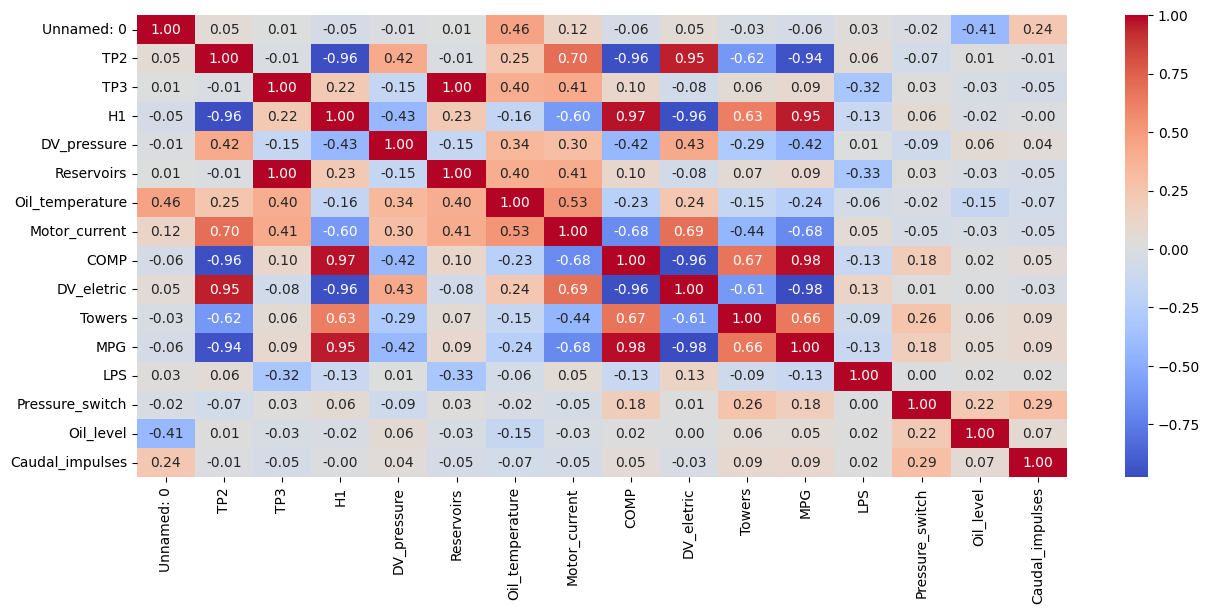

In [5]:
# Correlation matrix
df_sub = df.copy()
df_sub.drop('timestamp', axis=1, inplace=True)
plt.figure(figsize=(15, 6))
sns.heatmap(df_sub.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

## **4. Visualization zoo**

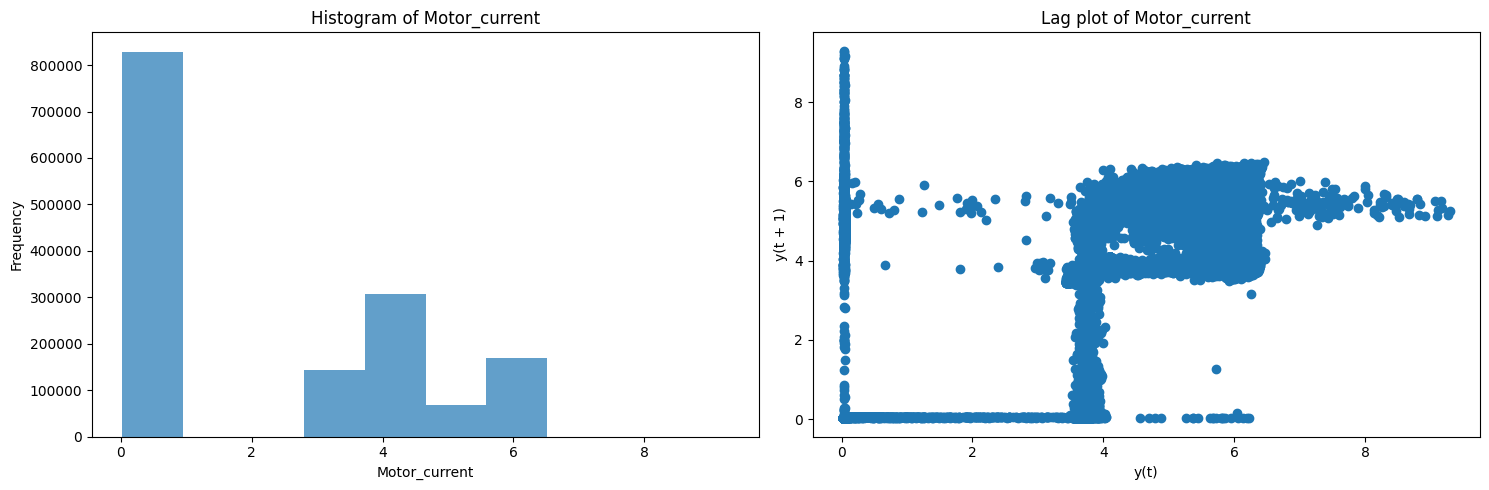

In [6]:
plt.figure(figsize=(15, 5))
n_rows, n_cols = 1, 2

plt.subplot(n_rows, n_cols, 1)
plt.hist(df['Motor_current'], alpha=0.7)
plt.xlabel('Motor_current')
plt.ylabel('Frequency')
plt.title('Histogram of Motor_current')

plt.subplot(n_rows, n_cols, 2)
# lag plot of Motor_current
pd.plotting.lag_plot(df['Motor_current'])
plt.title('Lag plot of Motor_current')

plt.tight_layout()
plt.show()

## **5. Rolling Window**

In [3]:
variable_name = "Oil_temperature"
df_day = df[[variable_name, 'timestamp']].copy().reset_index(drop=True) 
data = df_day[variable_name]
timestamp = df_day['timestamp']

# Ventana de x días
window_days = 24
split_percent = 0.8
window_size = 60*24*window_days * 6 # df_rows_per_minute
train_size = int(window_size * split_percent)
test_size = window_size - train_size

fig, ax = plt.subplots(figsize=(12, 5))
line, = ax.plot(timestamp, data, color='red', label=variable_name)
legend_patches = [
    Patch(color='green', alpha=0.3, label='Train'),
    Patch(color='blue', alpha=0.3, label='Test'),
    line
]
ax.set_xlim(timestamp.min(), timestamp.max())
ax.set_ylim(data.min(), data.max())
ax.set_xlabel('Timestamp')
ax.set_ylabel(f'{variable_name} value')
ax.set_title(f'whole 7 months, {window_days} days window')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H'))
ax.legend(handles=legend_patches, loc='upper left')
plt.tight_layout()

# Inicializar lista de parches
patches: list[Rectangle] = []
def update(frame) -> list[Rectangle]:
    global patches
    # Eliminar parches anteriores
    for p in patches:
        p.remove()
    patches = []

    start = frame
    end_train = start + train_size
    end_test = end_train + test_size

    # Añadir nuevos parches
    train_patch = ax.axvspan(timestamp[start], timestamp[end_train], color='green', alpha=0.3, label='Train' if frame == 0 else "")
    test_patch = ax.axvspan(timestamp[end_train], timestamp[end_test], color='blue', alpha=0.3, label='Test' if frame == 0 else "")
    patches = [train_patch, test_patch]

    return [line] + patches

FRAME_CUT = 50000
FPS = 10
custom_animation = animation.FuncAnimation(fig, update, frames=range(0, len(df_day) - window_size, FRAME_CUT), interval=1000/FPS, blit=False) # 1000/interval = fps
plt.close(fig)
# start = time.time()
# custom_animation.save("sliding_window.gif", writer="pillow", fps=FPS)
# minutos, segundos = divmod(time.time() - start, 60)
# print(f"Tiempo GIF: {int(minutos)} minutos {segundos:.2f} segundos")

HTML(custom_animation.to_jshtml()) # same seconds as GIF

## **6. Impute missing values**

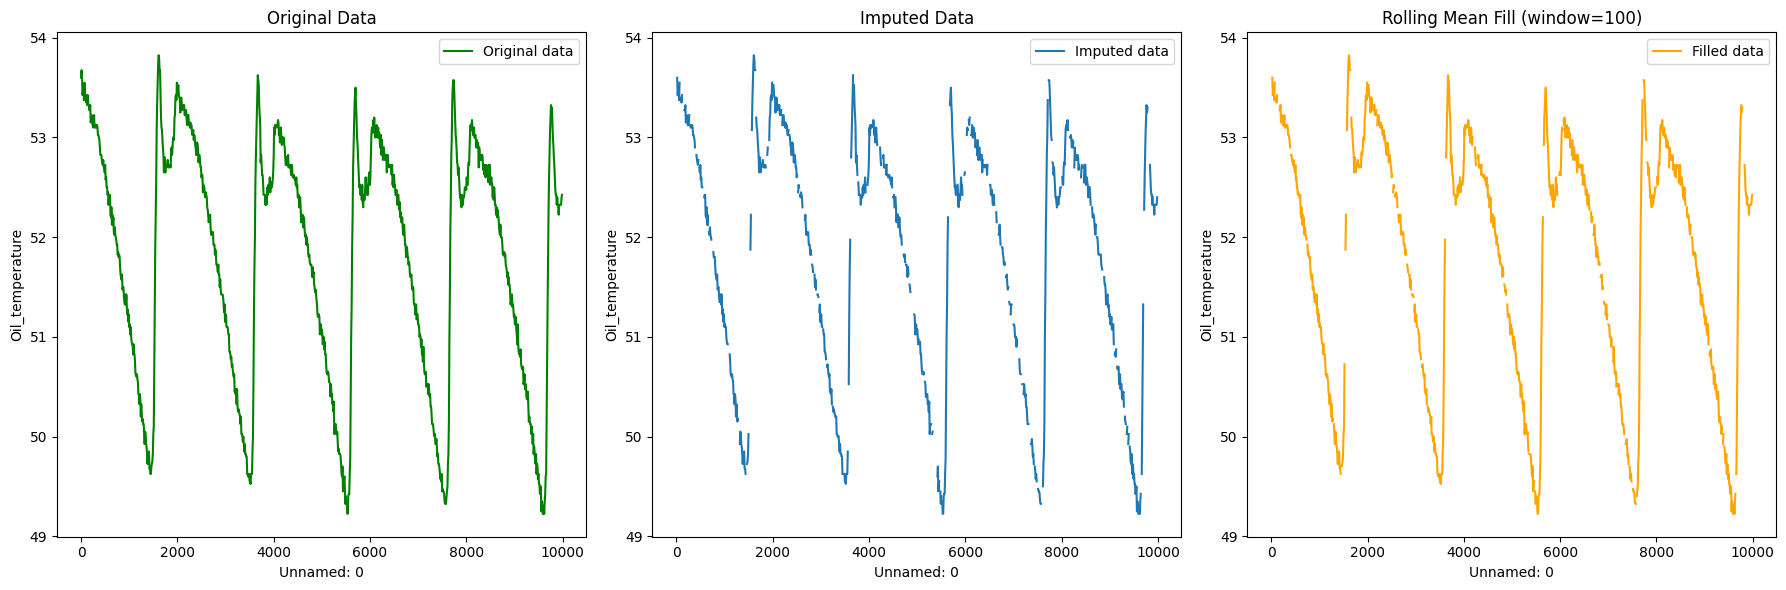

In [93]:
df_copy = df.copy()
mask_dataframe = df_copy.mask(np.random.random(df_copy.shape) < 0.1, other=pd.NA)
filled = mask_dataframe.copy()
filled['Unnamed: 0'] = df_copy['Unnamed: 0']
filled['Oil_temperature'] = filled['Oil_temperature'].fillna(filled['Oil_temperature'].rolling(window=100).mean())

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(df_copy['Unnamed: 0'][:1000], df_copy['Oil_temperature'][:1000], label='Original data', color='green')
plt.xlabel('Unnamed: 0')
plt.ylabel('Oil_temperature')
plt.title('Original Data')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(mask_dataframe['Unnamed: 0'][:1000], mask_dataframe['Oil_temperature'][:1000], label='Imputed data')
plt.xlabel('Unnamed: 0')
plt.ylabel('Oil_temperature')
plt.title('Imputed Data')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(filled['Unnamed: 0'][:1000], filled['Oil_temperature'][:1000], label='Filled data', color='orange')
plt.xlabel('Unnamed: 0')
plt.ylabel('Oil_temperature')
plt.title('Rolling Mean Fill (window=100)')
plt.legend()

plt.tight_layout()
plt.show()

## **7. Augmented Dickey-Fuller (ADF) test**

In [8]:
result = adfuller(df['Oil_temperature'].loc[:1000])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

ADF Statistic: -3.89785129258324
p-value: 0.0020507174402654266
Critical Values: {'1%': np.float64(-3.4369994990319355), '5%': np.float64(-2.8644757356011743), '10%': np.float64(-2.5683331327427803)}
